### 지역별 상점 최적입지 선정

* [데이터 정제](#chapter1)
    * [지역별(법정동) 성별 연령별 주민등록 인구수](#section_1_1)
        * [melt 함수](#section_1_1_1)
        * [concat 함수](#section_1_1_2)
    * [성별 업종별 소비](#section_1_2)
        * [filter(), sum()](#section_1_2_1)
        * [데이터 프레임 만들기](#section_1_2_2)
    * [연령별 업종 소비](#section_1_3)    
        * [그룹 분석 통계](#section_1_3_1)
        * [데이터 프레임 만들기](#section_1_3_2)
    * [시군구 위도 경도](#section_1_4)
        * [GeoDataFrame](#section_1_4_1)
* [시각화](#chapter2)
    * [성별 업종별 소비 시각화](#section_2_1)
    * [연령별 업종 소비 시각화](#section_2_2)
    * [인구피라미드 시각화](#section_2_3)
    * [folium 시각화](#section_2_4)

# 데이터 정제 <a class="anchor" id="chapter1"></a>


In [3]:
import pandas as pd
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon
from shapely.geometry import Point, Polygon, LineString
import numpy as np
import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

from learntools.core import binder
binder.bind(globals())

## 지역별(법정동) 성별 연령별 주민등록 인구수<a class="anchor" id="section_1_1"></a>

In [5]:
data_file="sex_age.csv"
f=pd.read_csv(data_file)
f

,법정동코드,통계년월,시도명,시군구명,읍면동명,리명,계,남자,여자,만0세남자,...,만101세여자,만102세여자,만103세여자,만104세여자,만105세여자,만106세여자,만107세여자,만108세여자,만109세여자,만110세이상여자
0,1111010100,2022-03-31,서울특별시,종로구,청운동,청운동,2335,1160,1175,4,...,1,0,0,0,0,0,0,0,0,0
1,1111010200,2022-03-31,서울특별시,종로구,신교동,신교동,1410,645,765,0,...,0,0,0,0,0,0,0,0,0,0
2,1111010300,2022-03-31,서울특별시,종로구,궁정동,궁정동,271,118,153,0,...,0,0,0,0,0,0,0,0,0,0
3,1111010400,2022-03-31,서울특별시,종로구,효자동,효자동,596,265,331,0,...,1,0,0,0,0,0,0,0,0,0
4,1111010500,2022-03-31,서울특별시,종로구,창성동,창성동,451,198,253,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18643,5013032022,2022-03-31,제주특별자치도,서귀포시,표선면,하천리,1273,643,630,2,...,0,0,0,0,0,0,0,0,0,0
18644,5013032023,2022-03-31,제주특별자치도,서귀포시,표선면,성읍리,1525,794,731,0,...,0,0,0,0,0,0,0,0,0,0
18645,5013032024,2022-03-31,제주특별자치도,서귀포시,표선면,가시리,1399,740,659,2,...,1,0,0,0,0,0,0,0,0,1
18646,5013032025,2022-03-31,제주특별자치도,서귀포시,표선면,세화리,1635,852,783,1,...,0,0,0,0,0,0,0,0,0,0


## melt 함수 <a class="anchor" id="section_1_1_1"></a>

### 파이썬에서는 데이터를 재구조화 하는데 한계가 있어 R에서 데이터 재구조화를 했다

In [ ]:
data_age_melt<-f
  select(-통계년월, -(시군구명:여자))%>%
  filter(시도명%in% c("서울특별시", "대전광역시", "대구광역시", "부산광역시")) %>%
  reshape2::melt(id.vars = c("법정동코드", "시도명"),
                 measure.vars = measure_col,
                 variable.name="나이_성별",
                 value.name = "인구수")%>%
  mutate(나이_성별 = as.character(나이_성별))

data_age_melt <-data_age_melt %>%
  mutate(age = gsub('\\D', '', 나이_성별) %>% as.integer(),
         sex = substring(나이_성별, nchar(나이_성별)-1, nchar(나이_성별)))
data_age_cat<-data_age_melt %>%
  mutate(age_cat = cut(age+0.1,
                       breaks = c(seq(0, 80, 10), 120) ,
                       labels = c("0~9", "10~19", "20~29", "30~39", "40~49", "50~59", "60~69", "70~79", "80세 이상"))) %>%
  group_by(시도명, age_cat) %>%
  summarise(전체_인구수 = sum(인구수))

In [4]:
data_file="official_age.csv"
df=pd.read_csv(data_file)
df

,시도명,시군구명,age_cat,sex,전체_인구수
0,강원도,강릉시,0~9,남자,6511
1,강원도,강릉시,0~9,여자,6123
2,강원도,강릉시,10~19,남자,9566
3,강원도,강릉시,10~19,여자,8660
4,강원도,강릉시,20~29,남자,13397
...,...,...,...,...,...
4495,충청북도,충주시,60~69,여자,17269
4496,충청북도,충주시,70~79,남자,7842
4497,충청북도,충주시,70~79,여자,9621
4498,충청북도,충주시,80세 이상,남자,4104


## concat 함수 <a class="anchor" id="section_1_1_2"></a>

In [107]:
d=df[df["sex"]=="남자"]
dd=d.groupby([ "age_cat"]).전체_인구수.sum()
dd
dd=pd.DataFrame(dd)
dd=dd.rename(columns={'age_cat':'age_cat','전체_인구수':'남자인구수'})
dd

,남자인구수
age_cat,
0~9,1895034
10~19,2425933
20~29,3458271
30~39,3450690
40~49,4143551
50~59,4367991
60~69,3547270
70~79,1704327
80세 이상,737517


In [111]:
d3=df[df["sex"]=="여자"]
dd3=d3.groupby([ "age_cat"]).전체_인구수.sum()
dd3
dd3=pd.DataFrame(dd3)
dd3=dd3.rename(columns={'age_cat':'age_cat','전체_인구수':'여자인구수'})
dd3

,여자인구수
age_cat,
0~9,1802700
10~19,2273981
20~29,3136054
30~39,3222734
40~49,4013995
50~59,4270705
60~69,3689864
70~79,2045517
80세 이상,1424561


In [112]:
data= pd.concat([dd,dd3], axis=1 )
data

,남자인구수,여자인구수
age_cat,,
0~9,1895034,1802700
10~19,2425933,2273981
20~29,3458271,3136054
30~39,3450690,3222734
40~49,4143551,4013995
50~59,4367991,4270705
60~69,3547270,3689864
70~79,1704327,2045517
80세 이상,737517,1424561


# 성별 업종별 소비 <a class="anchor" id="section_1_2"></a>

| 열 이름          |        내용 |     내용2           
| :-------------   |:----------- | :----------- 
| stdr_ym          |       날짜  |
|induty_nm         |       업종명|
|sexdstn_code      |     성별코드| 1:남자, 2:여자
|agrde_code|부가적 성별 표시 코드|
|setle_cascnt      |     구매금액|
|setle_amount      |     구매건수|

In [9]:
data_file="LTC.csv"
df4=pd.read_csv(data_file)
df4

,stdr_ym,induty_nm,sexdstn_code,agrde_code,setle_cascnt,setle_amount
0,202001,백화점,1,1,306,2.015844e+07
1,202001,백화점,1,2,47115,4.953897e+09
2,202001,백화점,1,3,254546,2.709540e+10
3,202001,백화점,1,4,377763,3.718161e+10
4,202001,백화점,1,5,274621,3.101029e+10
...,...,...,...,...,...,...
667,202012,편의점,2,3,764960,6.058394e+09
668,202012,편의점,2,4,1153507,9.036649e+09
669,202012,편의점,2,5,794045,5.931310e+09
670,202012,편의점,2,6,206028,1.750292e+09


### filter(), sum() <a class="anchor" id="section_1_2_1"></a>

In [10]:
setle_amount_sum=df4.groupby(['induty_nm', 'sexdstn_code']).setle_amount.sum()
setle_amount_sum

induty_nm  sexdstn_code
백화점        1               1.329993e+12
           2               3.298904e+12
슈퍼마켓       1               9.032866e+11
           2               1.452307e+12
편의점        1               3.969092e+11
           2               3.200559e+11
할인점        1               8.461080e+11
           2               1.414180e+12
Name: setle_amount, dtype: float64

In [19]:
setle_cascnt_sum=df4.groupby(["induty_nm", "sexdstn_code"]).setle_cascnt.sum()
setle_cascnt_sum

induty_nm  sexdstn_code
백화점        1               11297737
           2               30942066
슈퍼마켓       1               47414816
           2               72596100
편의점        1               52092789
           2               45123287
할인점        1               19715520
           2               35876941
Name: setle_cascnt, dtype: int64

### 데이터 프레임 만들기<a class="anchor" id="section_1_2_2"></a>

In [21]:
## 지수를 숫자로 바꿈
pd.options.display.float_format='{:.2f}'.format

In [13]:
finally_setle_amount=pd.DataFrame(setle_amount_sum)
finally_setle_amount

setle_amount
induty_nm sexdstn_code                 
백화점       1            1329993265704.00
          2            3298903506997.00
슈퍼마켓      1             903286627790.00
          2            1452306972402.00
편의점       1             396909237818.00
          2             320055884441.00
할인점       1             846108020576.00
          2            1414179625410.00

In [16]:
finally_setle_cascnt=pd.DataFrame(setle_cascnt_sum)
finally_setle_cascnt

setle_cascnt
induty_nm sexdstn_code              
백화점       1                 11297737
          2                 30942066
슈퍼마켓      1                 47414816
          2                 72596100
편의점       1                 52092789
          2                 45123287
할인점       1                 19715520
          2                 35876941

# 연령별 업종 소비 <a class="anchor" id="section_1_3"></a>

| 열 이름          |        내용 |
| :------------- |:-----------|
|   BASE_YEAR      |       연도  |
|   BASE_MONTH     |         월  |
|   CATE_DC        |     업종명  |
|   AGE_DC         |     연령대  |
|   CSP_PC         |     소비금액|

In [22]:
data_file="age_pay.csv"
df3=pd.read_csv(data_file)
df3

,BASE_YEAR,BASE_MONTH,CATE_DC,AGE_DC,CSP_PC
0,2016,1,생활서비스,60대이상,38874594351
1,2016,1,소매,10대,119567543
2,2016,1,소매,20대,43456132643
3,2016,1,소매,30대,150194114458
4,2016,1,소매,40대,191549052105
...,...,...,...,...,...
1291,2021,12,의료,30대,127850814540
1292,2021,12,의료,40대,212602208157
1293,2021,12,의료,50대,216070618809
1294,2021,12,의료,60대이상,138831608391


##  그룹 분석 통계 <a class="anchor" id="section_1_3_1"></a>


In [24]:
age_pay=df3.groupby(["CATE_DC", "AGE_DC"]).CSP_PC.sum()
age_pay

CATE_DC   AGE_DC
생활서비스     10대           1246979709
          20대         220265289163
          30대         350675740956
          40대         427588703881
          50대         971825194260
          60대이상      2893038174725
소매        10대           6015396925
          20대        3519403606614
          30대       11148350209053
          40대       13554615400913
          50대       10741672229604
          60대이상      5572840384130
음식        10대           5753892524
          20대        2884545506155
          30대        7451698437847
          40대        8573823811337
          50대        5581403071378
          60대이상       452195880173
의료        10대           2099300429
          20대        2116908507726
          30대        7011451412667
          40대        9825361022069
          50대        9551419414990
          60대이상      5780008301568
프랜차이즈_소매  10대            475735416
프랜차이즈_음식  10대            687531993
Name: CSP_PC, dtype: int64

In [26]:
age_pay_1=df3.groupby(["CATE_DC"]).CSP_PC.sum()
age_pay_1

CATE_DC
생활서비스        4864640082694
소매          44542897227239
음식          24949420599414
의료          34287247959449
프랜차이즈_소매         475735416
프랜차이즈_음식         687531993
Name: CSP_PC, dtype: int64

In [27]:
d=age_pay_ratio=age_pay/age_pay_1
d

CATE_DC   AGE_DC
생활서비스     10대      0.00
          20대      0.05
          30대      0.07
          40대      0.09
          50대      0.20
          60대이상    0.59
소매        10대      0.00
          20대      0.08
          30대      0.25
          40대      0.30
          50대      0.24
          60대이상    0.13
음식        10대      0.00
          20대      0.12
          30대      0.30
          40대      0.34
          50대      0.22
          60대이상    0.02
의료        10대      0.00
          20대      0.06
          30대      0.20
          40대      0.29
          50대      0.28
          60대이상    0.17
프랜차이즈_소매  10대      1.00
프랜차이즈_음식  10대      1.00
Name: CSP_PC, dtype: float64

## 데이터 프레임 만들기 <a class="anchor" id="section_1_3_2"></a>

In [28]:
d1=pd.DataFrame(d)
d1

CSP_PC
CATE_DC  AGE_DC        
생활서비스    10대       0.00
         20대       0.05
         30대       0.07
         40대       0.09
         50대       0.20
         60대이상     0.59
소매       10대       0.00
         20대       0.08
         30대       0.25
         40대       0.30
         50대       0.24
         60대이상     0.13
음식       10대       0.00
         20대       0.12
         30대       0.30
         40대       0.34
         50대       0.22
         60대이상     0.02
의료       10대       0.00
         20대       0.06
         30대       0.20
         40대       0.29
         50대       0.28
         60대이상     0.17
프랜차이즈_소매 10대       1.00
프랜차이즈_음식 10대       1.00

In [29]:
finally_age_pay=pd.DataFrame(age_pay)
finally_age_pay

CSP_PC
CATE_DC  AGE_DC                
생활서비스    10대         1246979709
         20대       220265289163
         30대       350675740956
         40대       427588703881
         50대       971825194260
         60대이상    2893038174725
소매       10대         6015396925
         20대      3519403606614
         30대     11148350209053
         40대     13554615400913
         50대     10741672229604
         60대이상    5572840384130
음식       10대         5753892524
         20대      2884545506155
         30대      7451698437847
         40대      8573823811337
         50대      5581403071378
         60대이상     452195880173
의료       10대         2099300429
         20대      2116908507726
         30대      7011451412667
         40대      9825361022069
         50대      9551419414990
         60대이상    5780008301568
프랜차이즈_소매 10대          475735416
프랜차이즈_음식 10대          687531993

# 시군구 위도 경도 <a class="anchor" id="section_1_4"></a>

In [32]:
data_file="test.csv"
df4=pd.read_csv(data_file)
df4

,시도명,시군구명,age_cat,sex,전체_인구수,latitude,longitude
0,경기도,화성시,40~49,남자,91908,126.87,37.17
1,경기도,화성시,30~39,남자,78583,126.87,37.17
2,경기도,부천시,50~59,남자,69771,126.79,37.50
3,경기도,화성시,50~59,남자,66754,126.87,37.17
4,경기도,남양주시,40~49,남자,66223,127.24,37.66
...,...,...,...,...,...,...,...
427,충청북도,제천시,80세 이상,남자,2722,128.14,37.06
428,충청북도,청주시 상당구,80세 이상,남자,2596,127.58,36.59
429,울산광역시,울주군,80세 이상,남자,2505,129.19,35.55
430,울산광역시,남구,80세 이상,남자,2349,129.33,35.52


In [133]:
data_file="test1.csv"
female=pd.read_csv(data_file)
female

,시도명,시군구명,age_cat,sex,전체_인구수,longitude,latitude
0,경기도,화성시,40~49,여자,81349,37.16524,126.8749
1,경기도,부천시,50~59,여자,74178,37.50426,126.7887
2,경기도,화성시,30~39,여자,71183,37.16524,126.8749
3,경기도,남양주시,40~49,여자,66238,37.66253,127.2437
4,경기도,부천시,40~49,여자,61716,37.50426,126.7887
...,...,...,...,...,...,...,...
427,울산광역시,울주군,80세 이상,여자,5571,35.54662,129.1869
428,충청북도,청주시 상당구,80세 이상,여자,5371,36.59211,127.5849
429,충청북도,제천시,80세 이상,여자,5105,37.05991,128.1410
430,울산광역시,남구,80세 이상,여자,4552,35.51605,129.3282


In [33]:
facilities_df = gpd.read_file("SIG_202005/SIG.shp", encoding = "cp949")
facilities_df

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."
...,...,...,...,...
245,48870,Hamyang-gun,함양군,"POLYGON ((1017715.723 1751280.191, 1017761.619..."
246,48880,Geochang-gun,거창군,"POLYGON ((1034571.593 1767759.812, 1034559.208..."
247,48890,Hapcheon-gun,합천군,"POLYGON ((1054066.576 1759517.415, 1054101.450..."
248,50110,Jeju-si,제주시,"MULTIPOLYGON (((874410.953 1480515.382, 874408..."


## GeoDataFrame <a class="anchor" id="section_1_4_1"></a>

In [126]:
area=gpd.GeoDataFrame.from_file("SIG_202005/SIG.shp", encoding = "cp949")
pt=pd.read_csv("test.csv")
pt['경도']=pt['longitude'].astype(float)
pt['위도']=pt['latitude'].astype(float)
pt['geometry']=pt.apply(lambda row:Point([row['경도'], row['위도']]), axis=1)
pt=gpd.GeoDataFrame( pt, geometry='geometry')

pt.crs = {'init': 'epsg:4326'}
#pt=pt.to_crs({'init':'epsg:5179'})
pt

C:\Users\lg\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\lg\anaconda3\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



,시도명,시군구명,age_cat,sex,전체_인구수,latitude,longitude,경도,위도,geometry
0,경기도,화성시,40~49,남자,91908,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
1,경기도,화성시,30~39,남자,78583,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
2,경기도,부천시,50~59,남자,69771,126.7887,37.50426,37.50426,126.7887,POINT (37.50426 126.78870)
3,경기도,화성시,50~59,남자,66754,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
4,경기도,남양주시,40~49,남자,66223,127.2437,37.66253,37.66253,127.2437,POINT (37.66253 127.24370)
...,...,...,...,...,...,...,...,...,...,...
427,충청북도,제천시,80세 이상,남자,2722,128.1410,37.05991,37.05991,128.1410,POINT (37.05991 128.14100)
428,충청북도,청주시 상당구,80세 이상,남자,2596,127.5849,36.59211,36.59211,127.5849,POINT (36.59211 127.58490)
429,울산광역시,울주군,80세 이상,남자,2505,129.1869,35.54662,35.54662,129.1869,POINT (35.54662 129.18690)
430,울산광역시,남구,80세 이상,남자,2349,129.3282,35.51605,35.51605,129.3282,POINT (35.51605 129.32820)


In [127]:
top=pt.sort_values(by='전체_인구수', ascending=False).groupby(['age_cat', '시도명']).head(1)
top

,시도명,시군구명,age_cat,sex,전체_인구수,latitude,longitude,경도,위도,geometry
0,경기도,화성시,40~49,남자,91908,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
1,경기도,화성시,30~39,남자,78583,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
2,경기도,부천시,50~59,남자,69771,126.7887,37.50426,37.50426,126.7887,POINT (37.50426 126.78870)
7,경기도,화성시,20~29,남자,59321,126.8749,37.16524,37.16524,126.8749,POINT (37.16524 126.87490)
8,경기도,부천시,60~69,남자,58845,126.7887,37.50426,37.50426,126.7887,POINT (37.50426 126.78870)
...,...,...,...,...,...,...,...,...,...,...
408,전라남도,여수시,80세 이상,남자,4303,127.6534,34.69811,34.69811,127.6534,POINT (34.69811 127.65340)
413,충청북도,충주시,80세 이상,남자,4104,127.8957,37.01520,37.01520,127.8957,POINT (37.01520 127.89570)
414,충청남도,아산시,80세 이상,남자,4060,126.9801,36.80732,36.80732,126.9801,POINT (36.80732 126.98010)
425,세종특별자치시,NaN,80세 이상,남자,2996,127.2588,36.56066,36.56066,127.2588,POINT (36.56066 127.25880)


In [130]:
area=gpd.GeoDataFrame.from_file("SIG_202005/SIG.shp", encoding = "cp949")
pt_1=pd.read_csv("test1.csv")
pt_1['경도']=pt_1['longitude'].astype(float)
pt_1['위도']=pt_1['latitude'].astype(float)
pt_1['geometry']=pt_1.apply(lambda row:Point([row['경도'], row['위도']]), axis=1)
pt_1=gpd.GeoDataFrame( pt_1, geometry='geometry')

pt_1.crs = {'init': 'epsg:4326'}
#pt=pt.to_crs({'init':'epsg:5179'})
pt_1

C:\Users\lg\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\lg\anaconda3\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



,시도명,시군구명,age_cat,sex,전체_인구수,longitude,latitude,경도,위도,geometry
0,경기도,화성시,40~49,여자,81349,37.16524,126.8749,37.16524,126.8749,POINT (37.16524 126.87490)
1,경기도,부천시,50~59,여자,74178,37.50426,126.7887,37.50426,126.7887,POINT (37.50426 126.78870)
2,경기도,화성시,30~39,여자,71183,37.16524,126.8749,37.16524,126.8749,POINT (37.16524 126.87490)
3,경기도,남양주시,40~49,여자,66238,37.66253,127.2437,37.66253,127.2437,POINT (37.66253 127.24370)
4,경기도,부천시,40~49,여자,61716,37.50426,126.7887,37.50426,126.7887,POINT (37.50426 126.78870)
...,...,...,...,...,...,...,...,...,...,...
427,울산광역시,울주군,80세 이상,여자,5571,35.54662,129.1869,35.54662,129.1869,POINT (35.54662 129.18690)
428,충청북도,청주시 상당구,80세 이상,여자,5371,36.59211,127.5849,36.59211,127.5849,POINT (36.59211 127.58490)
429,충청북도,제천시,80세 이상,여자,5105,37.05991,128.1410,37.05991,128.1410,POINT (37.05991 128.14100)
430,울산광역시,남구,80세 이상,여자,4552,35.51605,129.3282,35.51605,129.3282,POINT (35.51605 129.32820)


In [131]:
ddd=pt_1.sort_values(by='전체_인구수', ascending=False).groupby(['age_cat', '시도명']).head(1)
ddd

,시도명,시군구명,age_cat,sex,전체_인구수,longitude,latitude,경도,위도,geometry
0,경기도,화성시,40~49,여자,81349,37.16524,126.8749,37.16524,126.8749,POINT (37.16524 126.87490)
1,경기도,부천시,50~59,여자,74178,37.50426,126.7887,37.50426,126.7887,POINT (37.50426 126.78870)
2,경기도,화성시,30~39,여자,71183,37.16524,126.8749,37.16524,126.8749,POINT (37.16524 126.87490)
5,경기도,부천시,60~69,여자,61270,37.50426,126.7887,37.50426,126.7887,POINT (37.50426 126.78870)
8,서울특별시,관악구,20~29,여자,56058,37.46738,126.9453,37.46738,126.9453,POINT (37.46738 126.94530)
...,...,...,...,...,...,...,...,...,...,...
401,충청북도,충주시,80세 이상,여자,8098,37.01520,127.8957,37.01520,127.8957,POINT (37.01520 127.89570)
403,세종특별자치시,NaN,70~79,여자,8016,36.56066,127.2588,36.56066,127.2588,POINT (36.56066 127.25880)
405,충청남도,아산시,80세 이상,여자,7921,36.80732,126.9801,36.80732,126.9801,POINT (36.80732 126.98010)
425,세종특별자치시,NaN,80세 이상,여자,6151,36.56066,127.2588,36.56066,127.2588,POINT (36.56066 127.25880)


# 시각화 <a class="anchor" id="chapter2"></a>

In [35]:
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set(style="darkgrid")


import numpy as np
import pandas as pd

# importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']=(10,10)

#### 폰트를 설정해주지 않으면 글씨가 정확히 나타나지 않는다

In [36]:
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus']=False

## 성별 업종별 소비 시각화 <a class="anchor" id="section_2_1"></a>

#### 성별에 따라 어느 업종을 더 많이 소비할까

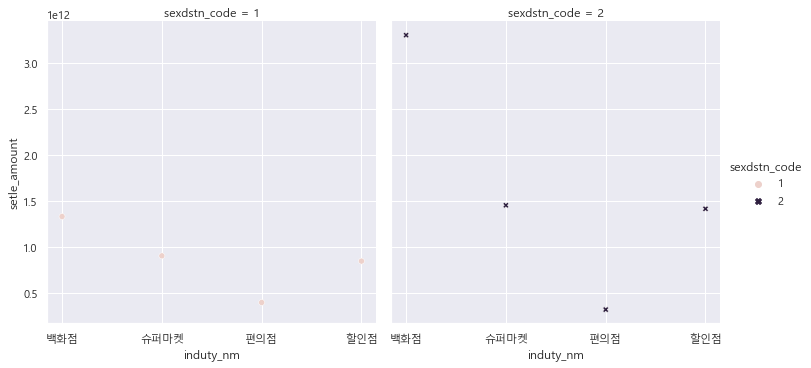

In [37]:
sns.relplot(x="induty_nm", y="setle_amount",hue='sexdstn_code',style='sexdstn_code',col='sexdstn_code',data=finally_setle_amount);

### 결과: 편의점을 제외한 다른 업종은 여자가 남자보다 구매건수, 구매금액 모두 높다는 것을 알 수 있다

## 연령별 업종 소비 데이터 <a class="anchor" id="section_2_2"></a>

#### 연령별로 어떤 업종을 많이 소비할까

In [39]:
finally_age_pay.reset_index(inplace=True)

<AxesSubplot:xlabel='AGE_DC', ylabel='CSP_PC'>

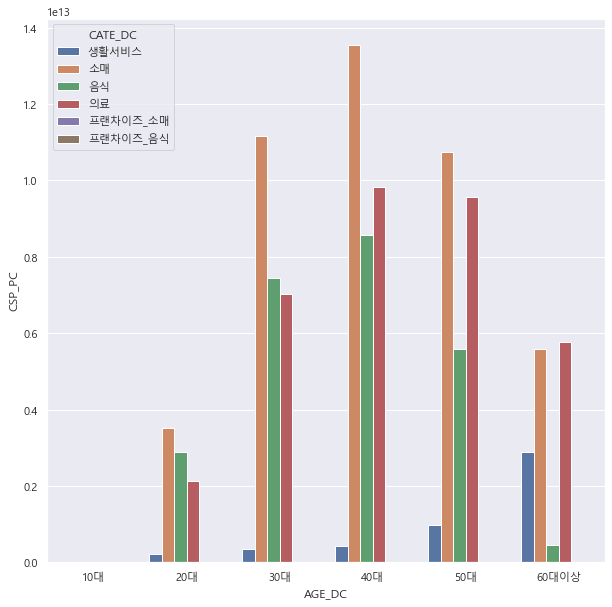

In [40]:
sns.barplot(x='AGE_DC', y="CSP_PC", hue="CATE_DC" ,data=finally_age_pay)

### 결과: 업종별,연령대 별 총소비금액으로 그린 그래프에서 10대는 다른 연령대에 비해 소비금액이 적어서 y축에 비율에 따라서 막대그래프가 나타나지 않았다. 20대, 30대, 40대, 50대는 소매 업종을 가장 많이 소비하고 60대이상은 의료업종을 제일 많이 소비하는 것을 알 수 있다.

In [41]:
d1.reset_index(inplace=True)

<AxesSubplot:xlabel='AGE_DC', ylabel='CSP_PC'>

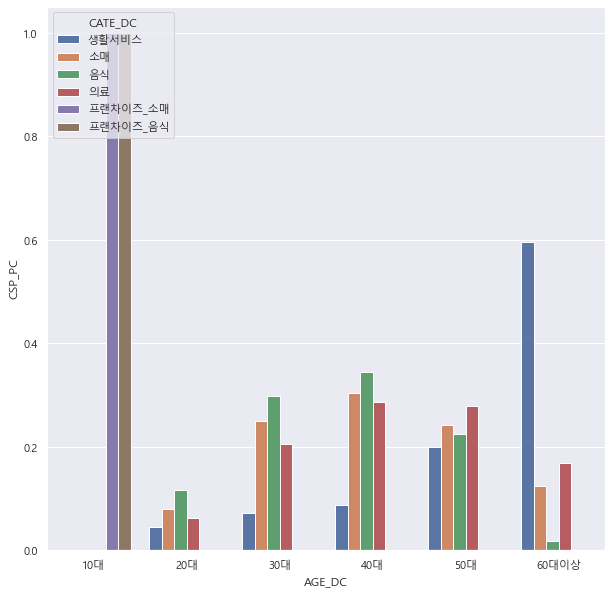

In [42]:
sns.barplot(x='AGE_DC', y="CSP_PC", hue="CATE_DC" ,data=d1)

### 결과: 업종별 전체 소비금액으로 각 업종 연령대별 소비금액을 나누어 비율로 나타낸 그래프에서 10대는 프렌차이즈 소매, 프렌차이즈 음식이 압도적으로 소비한다는 것을 알 수 있고 20, 30, 40대는 음식업종, 50대는 의료, 60대이상은 생활서비스가 많다는 것을 알 수 있다.


## 인구피라미드 시각화 <a class="anchor" id="section_2_3"></a>

#### 연령대별로 남성이 많을까 여성이 많을까


In [41]:
import plotly.graph_objs as go

In [114]:
data.reset_index(inplace=True)

In [115]:
age_sqmt=data["age_cat"]
male_data=data["남자인구수"]*-1
female_data=data["여자인구수"]

In [116]:
fig = go.Figure()
fig.add_trace(go.Bar(x=male_data,
                    y=age_sqmt,
                    name='남성',
                    orientation='h',
                    text=round(-1*male_data/10000, 1)))
fig.add_trace(go.Bar(x=female_data,
                    y=age_sqmt,
                    name='여성',
                    orientation='h',
                    text=round(female_data/10000, 1)))
fig.update_layout(title="연령대별 남성과 여성 비율 피라미드",
                  title_font_size=22,
                  barmode="overlay",
                  bargap=0.0,
                  bargroupgap=0,
                  xaxis=dict(tickvals =[-4000000, -3000000, -2000000, -1000000, 0,
                                       1000000, 2000000, 3000000, 4000000],
                             ticktext=["400만", "300만", "200만", "100만", "0", "100만", "200만", "300만", "400만"],
                             title="인구수(백만)",
                             title_font_size=14))
                  
fig.show()


### 결과:  0 ~ 59세는 남자가 더 많고 60 ~ 80세이상은 여성이 더많다.

## folium 시각화 <a class="anchor" id="section_2_4"></a>

In [123]:
import folium
import requests
import json
import os
from pandas.io.json import json_normalize
from folium import Choropleth, Circle, Marker
from folium import plugins 
print(folium.__version__)

0.12.1.post1


In [125]:
m = folium.Map(location=[126, 36], tiles='openstreetmap', zoom_start=2)
# Add points to the map
for idx, row in dd.iterrows():
    Marker([row['longitude'], row['latitude']], popup=row['시군구명']).add_to(m)

for idx, row in dd.iterrows():
    folium.CircleMarker(
         location=[row['longitude'], row['latitude']],
         radius=10,
         color="red",
         fill_color="white",
         popup=row['시군구명']).add_to(m)
m


In [132]:
m = folium.Map(location=[126, 36], tiles='openstreetmap', zoom_start=2)
# Add points to the map
for idx, row in ddd.iterrows():
    Marker([row['longitude'], row['latitude']], popup=row['시군구명']).add_to(m)

for idx, row in ddd.iterrows():
    folium.CircleMarker(
         location=[row['longitude'], row['latitude']],
         radius=10,
         color="red",
         fill_color="white",
         popup=row['시군구명']).add_to(m)
m

## 결과: 여자 남자 각각 따로 뽑아  연령대별로 가장 높은 인구수를 가지고 있는 지역을 연령대별로 1나씩 뽑았다. 뽑은 것을 바탕으로 맵핑을 한 결과 남자 여자 시도별로 지역이 몰려있다는 걸 알 수 있다.  

### 최종적 결과: 연령대와 시도명을 그룹바이하여 전체인구수를 기준으로 내림차순으로 나타내 연령대별로 전체인구수가 가장큰상위1개 자치행정동을 뽑아 지도위에 나타내었습니다. 이 지도는 남자만을 뽑아 연령대별, 지역별로 어느 곳에 많이 거주하는지 알 수 있습니다. 연령대별로 구분했지만 지도를 보면 지역별로 거리상 가까운것을 볼 수 있습니다, 결과적으로 앞에 시각화에서 봤듯이 남성이 많이 이용하는 편의점이나 남성비율이 많은0~50대가 많이이용하는 음식점 등을 중점적으로 볼 때 지도에서 나타낸 10m주변까지를 최적입지로 선정하였습니다. 그 다음 지도는 여성 연령별 인구 분포 지역을 나타낸 지도입니다. 여성이 많이 이용하는 백화점이나 할인점 여성이 많이 분포한 60대이상이 많이 이용하는 생활서비스등에 업종을 중점적으로 볼 때 지도에서 10m주변까지를  최적입지로 선정하였습니다. 